# Project 2: fire in the nature park

Laura Santa Cruz<br>
Intelligent data Analysis and Machine learning <br>
University of Potsdam 2024<br>

## 1. Introduction and problem setting

The administration of the nature park Montesinho wants to **predict wild fires based on wheather data of the Fire-Wheather-Index (FWI)**. The aim is to recognize the affected area and consequently the intensity of the imminent wild fire as early as possible in order to be able to adequatly assess the danger caused by the fire.

Data: 
    Collected from 517 wild fires containing following features: 

    X       X-coordinate of the fire in the park: 1 to 9 
    Y       Y-coordinate of the fire in the park: 2 to 9 
    month   month: ”jan“ to ”dec"
    day     day: ”mon“ bis ”sun“
    FFMC    FFMC index of the FWI system: 18.7 to 96.2
    DMC     DMC index of the FWI system: 1.1 to 291.3
    DC      DC index of the system: 7.9 to 860.6
    ISI     ISI index of the FWI systems: 0.0 to 56.1
    temp    temperature in degrees Celsius: 2.2 to 33.3
    RH      relative humidity in %: 15 to 100
    wind    wind velocity in km/h: 0.4 to 9.4
    rain    rainfall in mm/m2: 0.0 to 6.4
    area    forest area that has been burnt in hectare (ha): 0.09 to 1090.84

Task:
    Develop a model that predicts the burnt forest **area** (our dependent variable) as accurately as possible from the given data.

### 1.1. Loading and inspection of the data

In order to have an overview of the dataset, some checks will be performed

In [632]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [633]:
fires = pd.read_csv('fires.csv')
fires

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [634]:
fires.describe() #for summary statistics

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Check for missing values:

In [635]:
if any(fires.isnull().sum()) != 0:
    print(fires.isnull().sum())
else: 
    print("No missing values.")

No missing values.


As we can see from this initial checks, the variables **'month' and 'day' are categorical** so we will need to enconde them in order to use them in the model. We can also plot these variables to visualize any months or days where fires happen more frequently:

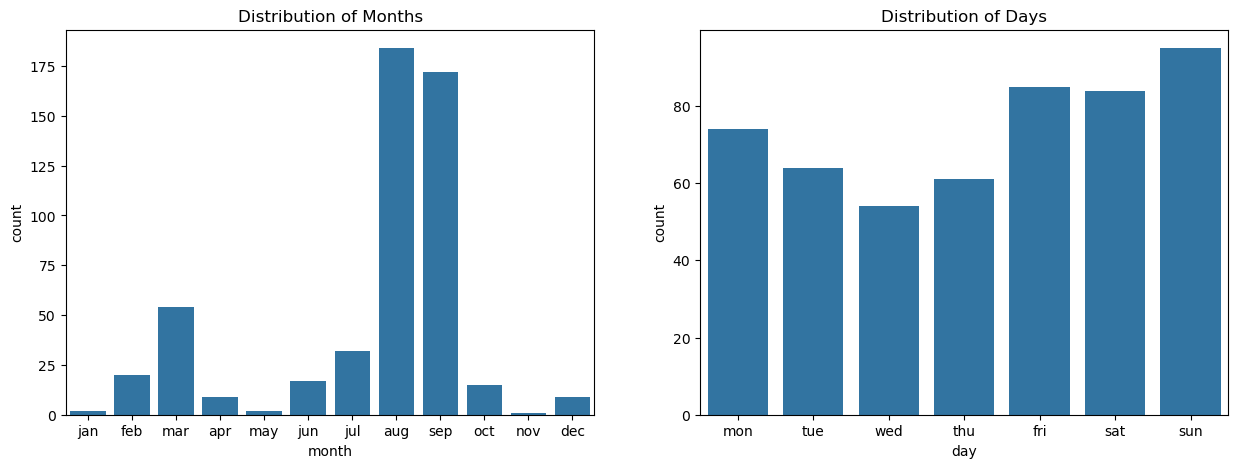

In [636]:
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']

# Convert month and day columns to ordered categorical types (for plotting purposes)
fires['month'] = pd.Categorical(fires['month'], categories=month_order, ordered=True)
fires['day'] = pd.Categorical(fires['day'], categories=day_order, ordered=True)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(fires, x='month')
plt.title("Distribution of Months")

plt.subplot(1,2,2)
sns.countplot(fires, x='day')
plt.title("Distribution of Days")
plt.show()

From plotting 'month' we can see most fires happen during the months of August and September. With respect to 'day', the data is more evenly distributed, but most fires happen during the Fridays, Saturdays and Sundays.

For the **numerical variables**, some like 'FFMC' (from 18.7 to 96.2) or 'DC' (from 7.9 to 860.6) have different varying scales so they need to be normalized. We can also check the distirbuion of the numerical to look for outliers and non-normal distributions:

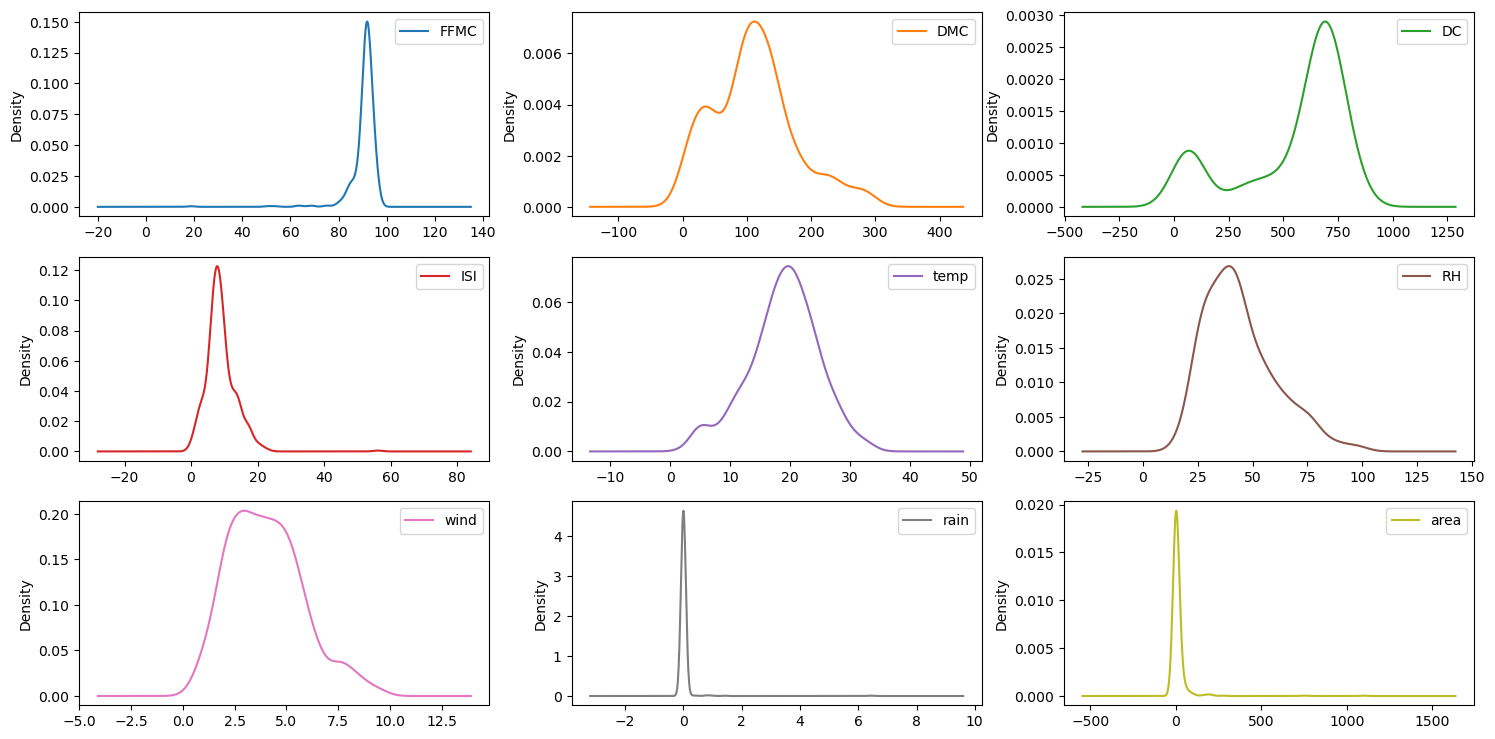

In [637]:
num_var = fires.loc[:, ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']]
num_var.plot(kind="density", subplots=True, layout=[3,3], figsize=[18,9], sharex=False, ylabel=False)
plt.show()

As we can see from the plots, 'FFMC', 'ISI', 'rain', 'RH' and 'area' are skewed, so in order to be able to use linear regression, we will need to transform and normalize our data.<br><br>

To better visualize the 'X' and 'Y' variables we can plot them in a heatmap as they represent coordinates, jointly with our dependent variable 'area'. It is worth mentioning that the variable 'area' contains many zero-value entries because burned areas smaller than (0.01 ha) 100m2 are counted as 0. 

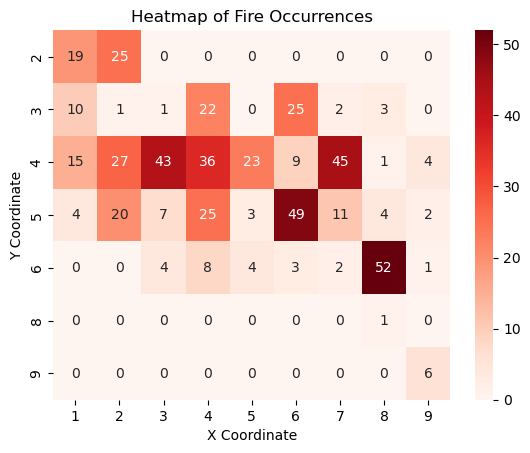

In [638]:
heatmap_data = pd.pivot_table(fires, values='area', index='Y', columns='X', aggfunc='count', fill_value=0)
sns.heatmap(heatmap_data, annot=True, cmap='Reds')
plt.title('Heatmap of Fire Occurrences')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

## 2. Data preparation and normalization

### 2.1. Data transformations

In order to make the data more suitable for modelling, some transformations need to be applied.<br><br>

The log transformation is commonly used for right-skewed distributions and in this case it was used for the variables 'ISI', 'RH', 'rain' and 'area'. On the other hand, the power transformation was used for the variable 'FFMC' as it is more suitable for left-skewed distributions. 

In [639]:
fires['area_log'] = np.log1p(fires.area)  # it applies log(1+x)
fires['rh_log'] = np.log1p(fires.RH)
fires['rain_log'] = np.log1p(fires.rain)
fires['isi_log'] = np.log1p(fires.ISI)

fires['ffmc_power'] = fires.FFMC ** 12 # power transformation

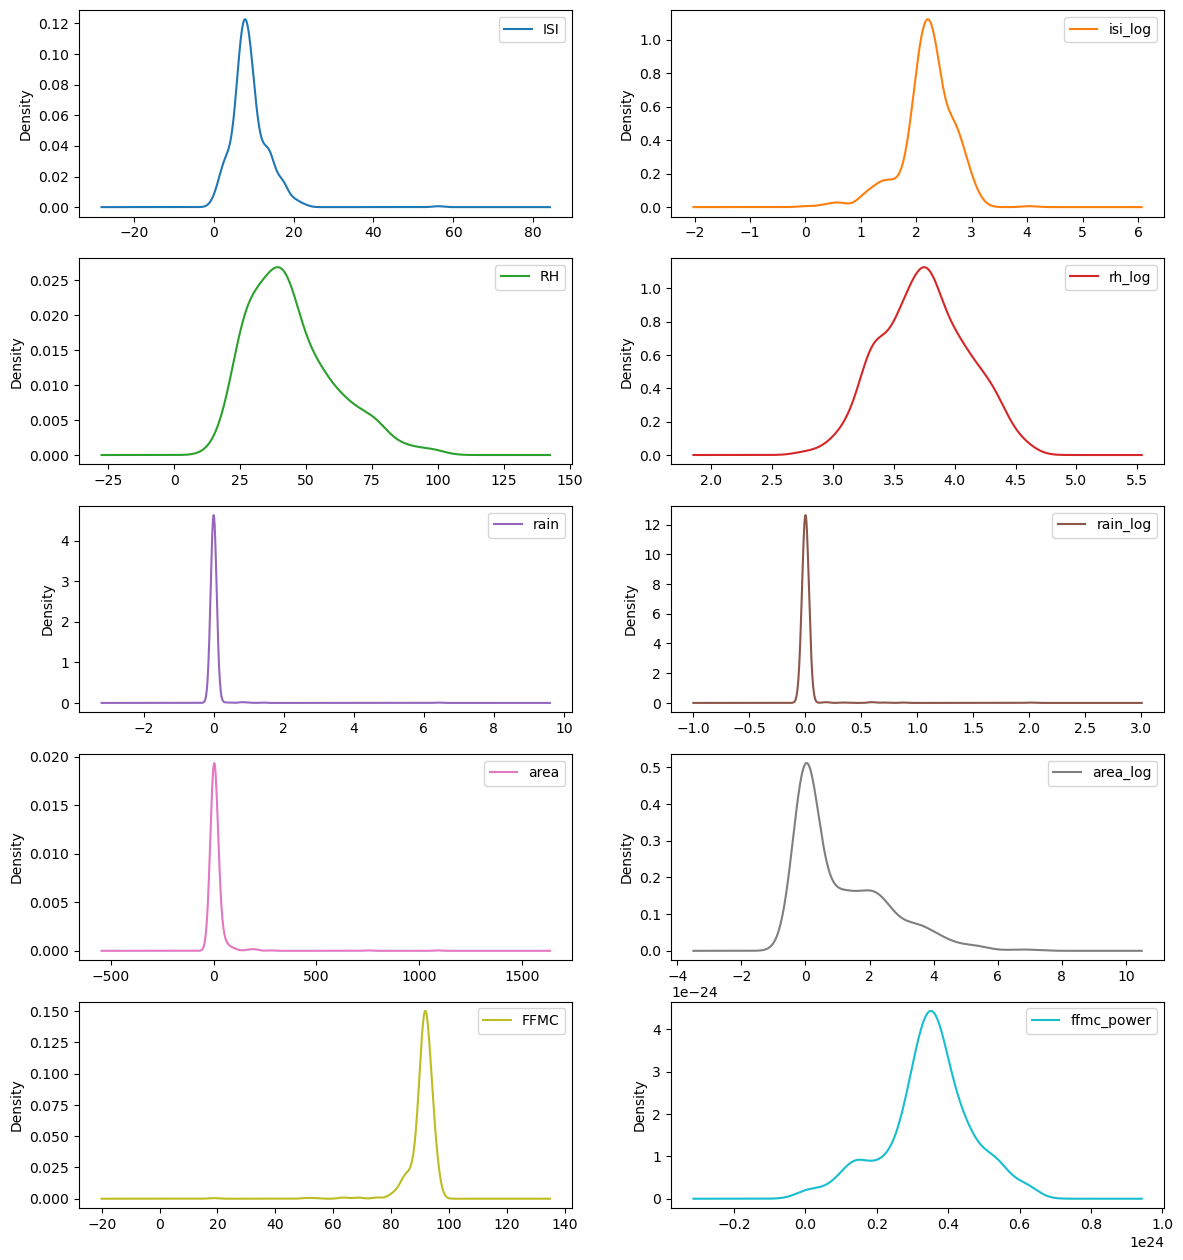

In [640]:
transf_var = fires.loc[:, ['ISI', 'isi_log', 'RH', 'rh_log', 'rain', 'rain_log', 'area', 'area_log', 'FFMC', 'ffmc_power']]
transf_var.plot(kind="density", subplots=True, layout=[7,2], figsize=[14,22], sharex=False, ylabel=False)
plt.show()

In [641]:
fires_area = fires.area #save original area values
fires = fires.drop(['ISI','RH','rain','area','FFMC'], axis=1) #keep the transformed values for the downstream analysis

One-hot encoding will be used, so no misleading assumptions of magnitude are introduced and to ensure each category is treated independently:

In [642]:
fires = pd.get_dummies(fires, columns=['month','day'], drop_first=False, dtype=int)
fires.head(5)

,X,Y,DMC,DC,temp,wind,area_log,rh_log,rain_log,isi_log,...,month_oct,month_nov,month_dec,day_mon,day_tue,day_wed,day_thu,day_fri,day_sat,day_sun
0,7,5,26.2,94.3,8.2,6.7,0.0,3.951244,0.000000,1.808289,...,0,0,0,0,0,0,0,1,0,0
1,7,4,35.4,669.1,18.0,0.9,0.0,3.526361,0.000000,2.041220,...,1,0,0,0,1,0,0,0,0,0
2,7,4,43.7,686.9,14.6,1.3,0.0,3.526361,0.000000,2.041220,...,1,0,0,0,0,0,0,0,1,0
3,8,6,33.3,77.5,8.3,4.0,0.0,4.584967,0.182322,2.302585,...,0,0,0,0,0,0,0,1,0,0
4,8,6,51.3,102.2,11.4,1.8,0.0,4.605170,0.000000,2.360854,...,0,0,0,0,0,0,0,0,0,1


### 2.2. Normalization and subsetting of the data

Normalization is done in order to scale the values so that they can be comparable. In this case, we will use min-max normalization as it preserves the shapes of the distributions.<br><br>

It is important to note that the scaling will just be done in the numerical variables ('month' and 'day' excluded) and 'X' and 'Y' were also not included as they represent coordinates. 

In [643]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [644]:
# Initialize the MinMaxScaler for the X and y
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
num_var = ['DMC', 'DC', 'temp', 'wind', 'rh_log', 'rain_log', 'isi_log', 'ffmc_power'] # X and Y not included as they represent coordinates.

# Split the dataset
X = fires.loc[:, fires.columns != 'area_log']
y = fires.loc[:,'area_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

X_train_scaled = X_train.copy() # to apply min/max only in the numerical varaibles
X_test_scaled = X_test.copy()

# Fitting and transforming the numerical variables of training data
X_train_scaled[num_var] = scaler_x.fit_transform(X_train[num_var])
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)) # reshape because MinMaxScaler expects 2D array

# Only transforming the numerical variables from test data!!
X_test_scaled[num_var] = scaler_x.transform(X_test[num_var])
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))


### 2.3. Check for correlations

Lastly, the Pearson correlation coefficient will be used to analyse pairwise correlations. The correlation coefficients range between -1 and 1, where positive/negative values indicate a positive/negative relationship between the variables (not to mistake with causality) and values close to 0 represent no linear correlation between them.<br>
It is also worth mentioning that the Pearson correlation coefficient is only able to measure correlation among two pairs of predictors, so we will not detect multicolinearity if any.

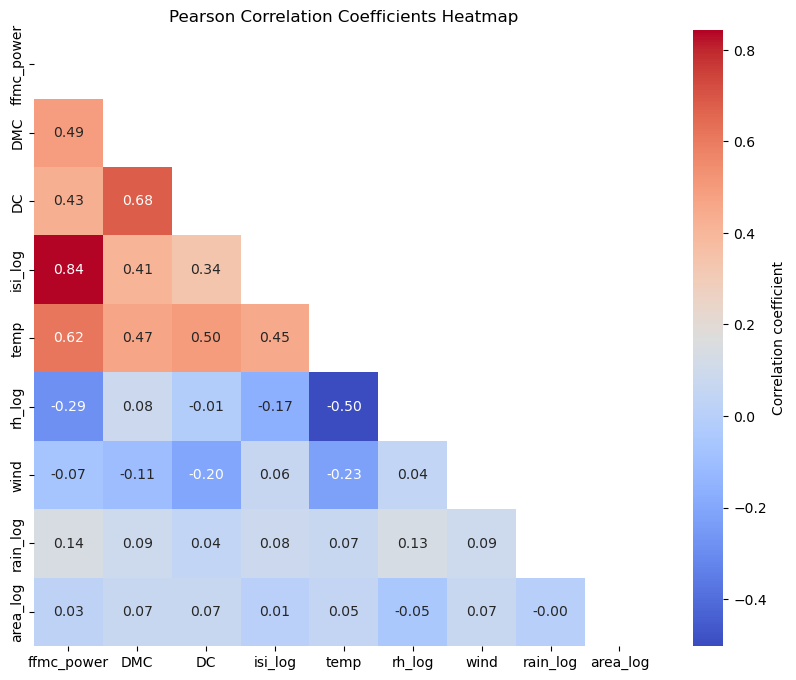

In [668]:
num_var = fires.loc[:, ['ffmc_power', 'DMC', 'DC', 'isi_log', 'temp', 'rh_log', 'wind', 'rain_log', 'area_log']]
correlation_matrix = num_var.corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) # upper triangular array (to show only half of the heatmap)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, cbar_kws={'label': 'Correlation coefficient'})
plt.title('Pearson Correlation Coefficients Heatmap')
plt.show()

The DMC and DC index appear to be the more strongly correlated predictors among all pairs, followed by ISI and DMC (both related to velocity of fire spread). Area is not strongly linearly correlated to any of the predictors.

## 3. Model creation


In [646]:
from sklearn.metrics import mean_squared_error, r2_score

### 3.1. Simple linear regression

The first model trained will be a simple linear regression model. It will serve as a baseline for comparison with other more complex models.

In [647]:
from sklearn.linear_model import LinearRegression

In [648]:
# Simple linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
y_pred_linear = model.predict(X_test_scaled)

**Evaluation:**<br> 
Since we have trained our model with scaled data, in order to calculate the evaluation metrics we need to revert the scale in order to get back the original measures.

In [649]:
# Regression error Characteristic (REC) curve function from https://amirhessam88.github.io/regression-error-characteristics-curve/
from scipy.integrate import simps

def REC(y_true , y_pred):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_true)):
            if np.linalg.norm(y_true[j] - y_pred[j]) / np.sqrt( np.linalg.norm(y_true[j]) **2 + np.linalg.norm(y_pred[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_true))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy, Epsilon) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon, Accuracy, AUC

In [665]:
y_test_rescale = scaler_y.inverse_transform(y_test_scaled)
y_pred_rescale = scaler_y.inverse_transform(y_pred_linear)

# Residuals
residuals_linear = y_test_rescale - y_pred_rescale

# Calculate evaluation metrics
mse_linear = mean_squared_error(y_test_rescale, y_pred_rescale)
rmse_linear = math.sqrt(mse_linear)
r2_linear = r2_score(y_test_rescale, y_pred_rescale)

# Determine correct predictions
correct_predictions = residuals_linear <= 0.0001
correct_percentage = np.mean(correct_predictions) * 100

# REC curve using function
deviation, accuracy, AUC = REC(y_test_rescale , y_pred_rescale)

print(f"Accuracy = ", round(correct_percentage, 1), "%")
print(f'MSE (rescaled, test): {mse_linear:.3f}')
print(f'RMSE (rescaled, test): {rmse_linear:.3f}')
print(f'R2 (rescaled, test): {r2_linear:.3f}')


Accuracy =  59.6 %
MSE (rescaled, test): 2.285
RMSE (rescaled, test): 1.512
R2 (rescaled, test): -0.040


/tmp/ipykernel_839/2379875301.py:27: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  AUC = simps(Accuracy, Epsilon) / End_Range


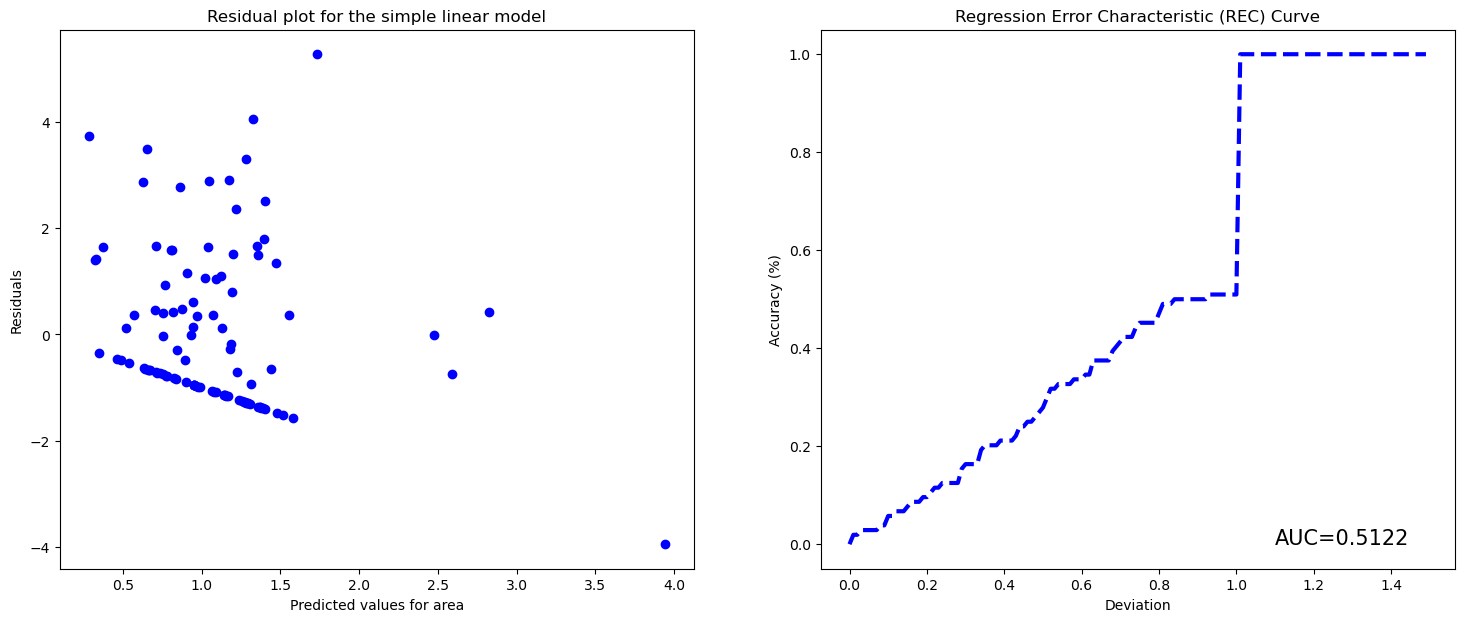

In [666]:
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_rescale, residuals_linear, color='blue')
# plt.ylim([-2, 4])
# plt.xlim([0, 3])
plt.title('Residual plot for the simple linear model')
plt.xlabel('Predicted values for area')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.plot(deviation, accuracy, '--b', lw=3)
plt.title('Regression Error Characteristic (REC) Curve')
plt.xlabel('Deviation')
plt.ylabel('Accuracy (%)')
plt.text(1.1, 0, "AUC=%0.4f" %AUC, fontsize=15 )
plt.show()

As we can see for the evaluation, the simple linear regression model appears to perform poorly:
- The high RMSE indicates a considerable deviation from the actual values. The high MSE (average square difference between observed and predicted) also indicates poor model performance
- R2 value (proportion of variance in the dependent that is predictable by the independent) indicates 0.0% of the variance is explained by the model, also a poor fit
- Residuals ideally would be randomly scattered around 0, however there seems to be some clustering near -1. This pattern suggests some possible under/overestimation of the data 
- Referring to the REC curve, the value of 0.5122 for AUC indicates that the model's predictive power is just slightly better than random guessing (the closer to 1 the better).

### 3.2. Ridge regression

The Ridge regression (also L2 regularization) is an extension of hte linear regression that includes a regularization term in the cost function. This regularization penalizes the size of the coefficients, reducing the variance in the model and making it more stable and less sensitive to multicolinearity.<br>
It is also usefull to mitigate overfitting, common in OLS linear regression and small datasets.<br>

In [652]:
from sklearn.linear_model import RidgeCV
from sklearn.kernel_ridge import KernelRidge

In [653]:
# Find best alpha: 
ridge_cv = RidgeCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10]).fit(X_train_scaled, y_train_scaled)
alpha_opt = ridge_cv.alpha_

# Create a Kernel Ridge Regression (KRR) model:
kernelridge = KernelRidge(kernel ='rbf', alpha=alpha_opt)
kernelridge.fit(X_train_scaled, y_train_scaled)
y_pred_kridge = kernelridge.predict(X_test_scaled)

**Evaluation:**


In [654]:
y_test_rescale = scaler_y.inverse_transform(y_test_scaled)
y_pred_rescale = scaler_y.inverse_transform(y_pred_kridge)

# Residuals
residuals_kridge = y_test_rescale - y_pred_rescale

# Calculate evaluation metrics
mse_kridge = mean_squared_error(y_test_rescale, y_pred_rescale)
rmse_kridge = math.sqrt(mse_linear)
r2_kridge = r2_score(y_test_rescale, y_pred_rescale)

# Determine correct predictions
correct_predictions = residuals_kridge <= 0.0001
correct_percentage = np.mean(correct_predictions) * 100

# REC curve using function
deviation, accuracy, AUC = REC(y_test_rescale , y_pred_rescale)

print(f"Accuracy = ", round(correct_percentage, 1), "%")
print(f'MSE (rescaled): {mse_kridge:.3f}')
print(f'RMSE (rescaled): {rmse_kridge:.3f}')
print(f'R2 (rescaled): {r2_kridge:.3f}')

Accuracy =  59.6 %
MSE (rescaled): 2.205
RMSE (rescaled): 1.512
R2 (rescaled): -0.003


/tmp/ipykernel_839/2379875301.py:27: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  AUC = simps(Accuracy, Epsilon) / End_Range


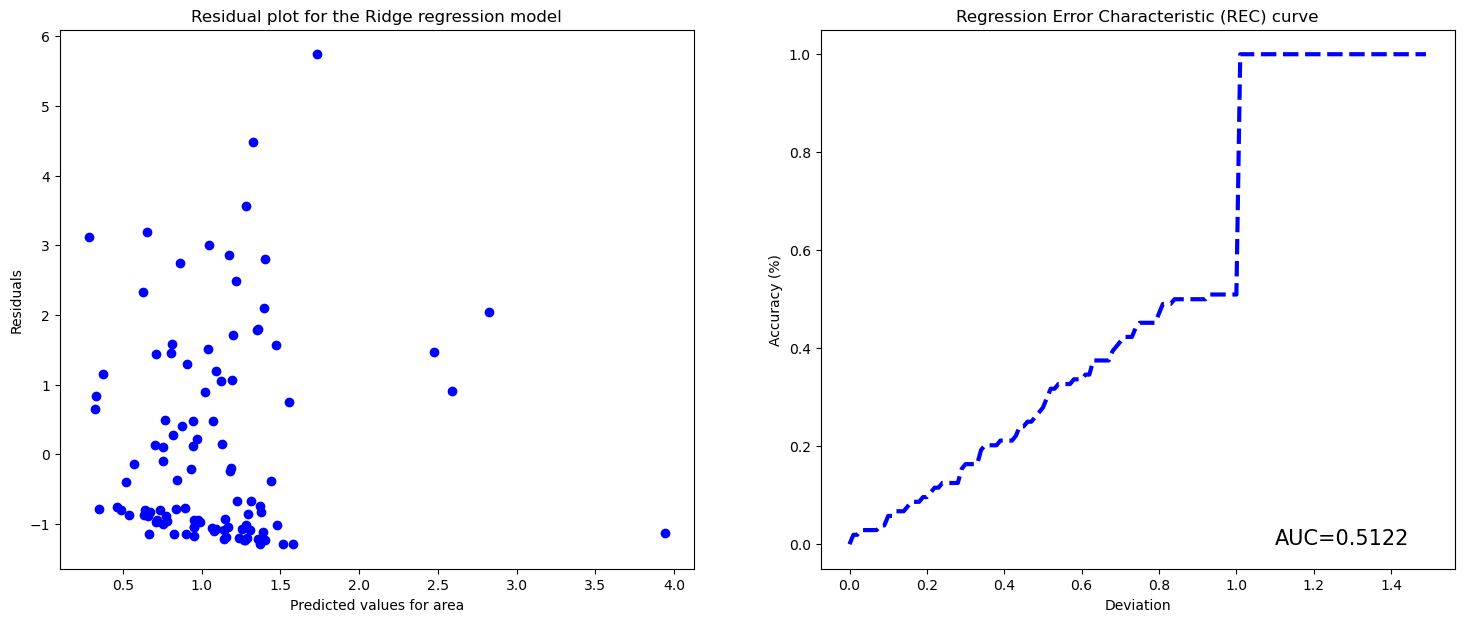

In [667]:
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_rescale, residuals_kridge, color='blue')
# plt.ylim([-2, 4])
# plt.xlim([0.5, 2])
plt.title('Residual plot for the Ridge regression model')
plt.xlabel('Predicted values for area')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.plot(deviation, accuracy, '--b', lw=3)
plt.title('Regression Error Characteristic (REC) curve')
plt.xlabel('Deviation')
plt.ylabel('Accuracy (%)')
plt.text(1.1, 0, "AUC=%0.4f" %AUC, fontsize=15 )
plt.show()

As we can see from the results, there is no performance improve in using a Ridge regression model for this data. This could indicate that the relationship between predictors and target is more complex and non-linear.

### 3.3. Random forest

As a more complex model, a Random Forest regressor will be used as it can capture non-linear relationships and will help us have a look at the feature importance.<br>

In [656]:
from sklearn.ensemble import RandomForestRegressor

In [657]:
forest = RandomForestRegressor()
forest.fit(X_train_scaled, y_train_scaled)
y_train_pred_scaled = forest.predict(X_train_scaled)
y_pred_scaled = forest.predict(X_test_scaled)

/home/laura/anaconda3/envs/machine/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


**Evaluation:**


In [671]:
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Calculate MSE and RMSE for training and test sets
mse_test = mean_squared_error(y_test_scaled, y_pred)
rmse_test = math.sqrt(mse_test)

mse_train = mean_squared_error(y_train_scaled, y_train_pred)
rmse_train = math.sqrt(mse_train)

# Calculate R^2 score on the test set
r2_forest = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'MSE (train) = {mse_train:.3f}; MSE (test) = {mse_test:.3f}')
print(f'RMSE (train) = {rmse_train:.3f}; RMSE (test) = {rmse_test:.3f}')
print(f'R2 = {r2_forest:.3f}')

# Residuals
residuals_forest = y_test.values.reshape(-1) - y_pred.reshape(-1)

# Determine correct predictions
correct_predictions = residuals_forest <= 0.0001
correct_percentage = np.mean(correct_predictions) * 100
print(f"Accuracy = ", round(correct_percentage, 1), "%")


MSE (train) = 1.420; MSE (test) = 1.237
RMSE (train) = 1.192; RMSE (test) = 1.112
R2 = -0.066
Accuracy =  62.5 %


## 4. Summary

## 5. Conclusion